In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import chi2_contingency
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import sys
sys.path.append("../src")

from risk_analysis_seg import segmentacao_risco_final_v2

In [2]:
file_path = "../artifacts/synthetic_personal_finance_dataset.csv"
df = pd.read_csv(file_path)
df.shape

(32424, 20)

In [3]:
# Solução provisória - criar categoria 'None' para quem não tem empréstimo
df['loan_type'] = df['loan_type'].fillna('None')

In [5]:
df = segmentacao_risco_final_v2(df)

# Questões a serem respondidas neste modelo;

"Qual a probabilidade de um cliente ser inadimplente com base em seu perfil financeiro e pessoal?"

"Quais variáveis mais influenciam a decisão de risco?"

In [6]:
df['target'] = (df['risco_final_v2'] == 'Alto Risco').astype(int)

X = df[[ 'monthly_income_usd', 'savings_usd', 'debt_to_income_ratio', 'savings_to_income_ratio', 'employment_status', 'region']]
y = df['target']


num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [8]:


model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])


AUC: 0.811
Brier Score: 0.175


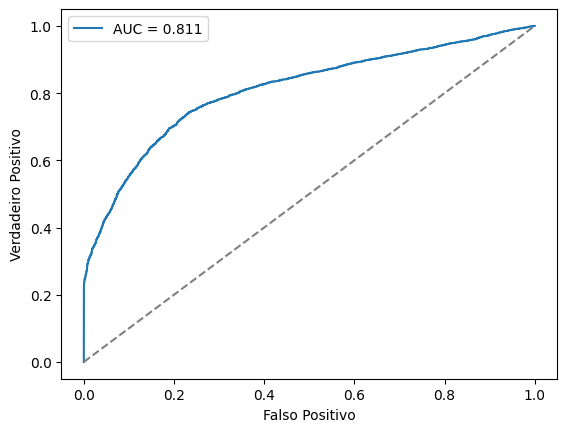

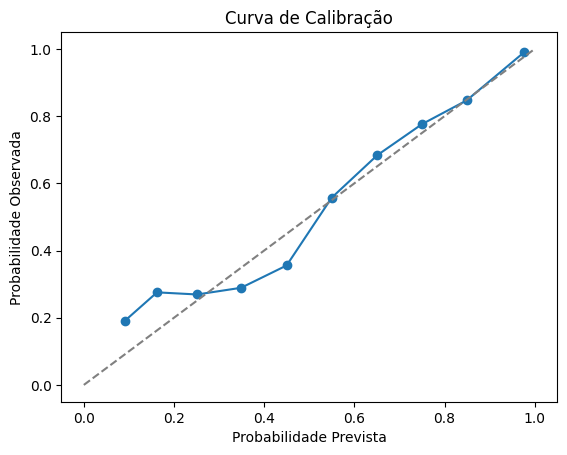

In [9]:

model.fit(X_train, y_train)


y_pred_prob = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
brier = brier_score_loss(y_test, y_pred_prob)

print(f"AUC: {auc:.3f}")
print(f"Brier Score: {brier:.3f}")


fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadeiro Positivo")
plt.legend()
plt.show()

# Calibração
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("Probabilidade Prevista")
plt.ylabel("Probabilidade Observada")
plt.title("Curva de Calibração")
plt.show()


# Otimizando as variaveis quanto a sua importância

In [10]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': result.importances_mean
}).sort_values(by='importance', ascending=False)

print(importance_df)



                   feature  importance
3  savings_to_income_ratio    0.227868
0       monthly_income_usd    0.083943
4        employment_status    0.064052
1              savings_usd    0.033789
5                   region    0.011534
2     debt_to_income_ratio    0.000339


KS Statistic: 0.510
Melhor Cut-off: 0.537


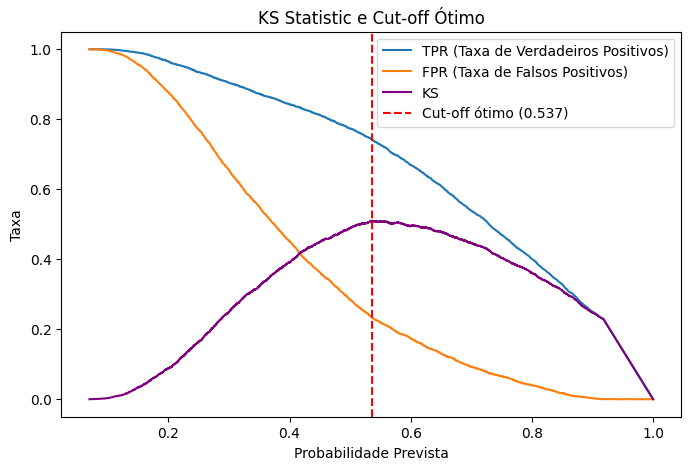

In [11]:



y_pred_prob = model.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)


ks_values = tpr - fpr
ks_stat = max(ks_values)
best_threshold = thresholds[np.argmax(ks_values)]

print(f"KS Statistic: {ks_stat:.3f}")
print(f"Melhor Cut-off: {best_threshold:.3f}")


import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(thresholds, tpr, label='TPR (Taxa de Verdadeiros Positivos)')
plt.plot(thresholds, fpr, label='FPR (Taxa de Falsos Positivos)')
plt.plot(thresholds, ks_values, label='KS', color='purple')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Cut-off ótimo ({best_threshold:.3f})')
plt.title('KS Statistic e Cut-off Ótimo')
plt.xlabel('Probabilidade Prevista')
plt.ylabel('Taxa')
plt.legend()
plt.show()


In [12]:
df_resultados = X_test.copy()
df_resultados['probabilidade_risco'] = y_pred_prob
df_resultados['risco_previsto_bin'] = np.where(df_resultados['probabilidade_risco'] >= best_threshold, 1, 0)

# Classificação em 3 níveis de risco
# Aqui definimos faixas arbitrárias que você pode ajustar:
# - Alto Risco: >= cut-off ótimo
# - Médio Risco: entre 0.3 e cut-off ótimo
# - Baixo Risco: < 0.3

def classificar_risco(prob):
    if prob >= best_threshold:
        return "Alto Risco"
    elif prob >= 0.3:
        return "Médio Risco"
    else:
        return "Baixo Risco"

df_resultados['risco_previsto_categoria'] = df_resultados['probabilidade_risco'].apply(classificar_risco)

# Visualizar amostra
print(df_resultados[['probabilidade_risco', 'risco_previsto_bin', 'risco_previsto_categoria']].head(10))


       probabilidade_risco  risco_previsto_bin risco_previsto_categoria
5181              0.631180                   1               Alto Risco
11620             0.398234                   0              Médio Risco
332               0.734346                   1               Alto Risco
7687              0.576882                   1               Alto Risco
9854              0.838835                   1               Alto Risco
5240              0.861220                   1               Alto Risco
1063              0.177451                   0              Baixo Risco
7151              0.743714                   1               Alto Risco
27769             0.998423                   1               Alto Risco
25959             0.225533                   0              Baixo Risco


Matriz de Confusão:
[[3197  966]
 [1437 4128]]

Relatório de Classificação:
              precision    recall  f1-score   support

 Baixo Risco       0.69      0.77      0.73      4163
  Alto Risco       0.81      0.74      0.77      5565

    accuracy                           0.75      9728
   macro avg       0.75      0.75      0.75      9728
weighted avg       0.76      0.75      0.75      9728



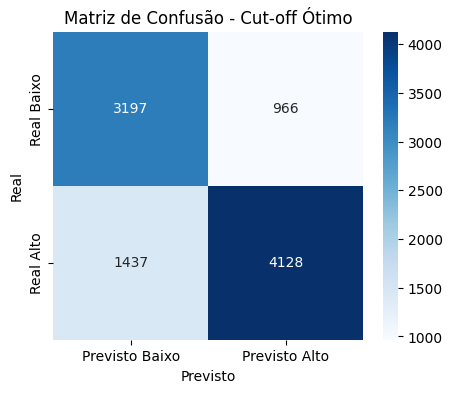

In [13]:
y_pred_bin = (y_pred_prob >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_bin)
print("Matriz de Confusão:")
print(cm)
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_bin, target_names=['Baixo Risco', 'Alto Risco']))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Previsto Baixo', 'Previsto Alto'], yticklabels=['Real Baixo', 'Real Alto'])
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.title('Matriz de Confusão - Cut-off Ótimo')
plt.show()


## 1) Interpretação de negócio / Recomendações de cut-off

Dependendo do objetivo de negócio (minimizar perda por inadimplência vs evitar reprovar bons clientes), escolha:

1. **Política Conservadora (minimizar FN — captar todos os de alto risco)**

   * Ajuste: **reduzir cut-off** para algo como 0.45–0.50
   * Efeito esperado: aumenta *recall* (menos FN), reduz *precision* (mais FP) — mais análises manuais/contato.

2. **Política Balanceada (KS cut-off = 0.537)**

   * Mantém o trade-off atual: boa precisão e recall razoável — boa escolha para operação inicial.

3. **Política Agressiva (minimizar FP — evitar recusas indevidas)**

   * Ajuste: **aumentar cut-off** para 0.58–0.65
   * Efeito: aumenta precision, reduz recall — menos clientes recusados injustamente, mas aumenta risco de conceder crédito a inadimplentes.


---

## 2) Validação e monitoramento (próximos passos)

* **PSI (Population Stability Index)**: calcule comparando população de aplicação com população de treinamento por bins (ex.: 10 bins) para detectar drift. Thresholds: PSI < 0.1 (ok), 0.1-0.25 (atenção), >0.25 (revisão).
* **Backtesting**: se possível, testar modelo em base temporal (simular scoring mês a mês) para medir degradação.

---


## 3 (próximos passos técnicos)

1. Calcule **PSI** para a base de produção versus base de treino.
2. Rodar **SHAP** para explicar previsões críticas (top FP e FN).
3. Implantar monitoramento (AUC, KS, taxa de aprovação, PSI) em dashboard (ex.: Power BI / Grafana).